## Predição de Turnover (Rotatividade) de Funcionários com Machine Learning

### 🔹Etapa 1 – Leitura e Exploração Inicial dos Dados
**Objetivo:**

Nesta etapa, será carregado o conjunto de dados para obter uma visão geral sobre suas características:

- Conhecer as variáveis disponíveis

- Identificar a variável alvo

- Investigar a estrutura e integridade dos dados

- Fazer as primeiras observações sobre possíveis padrões ou problemas

### 1.1 Importando bibliotecas

In [85]:
# importando bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math 
import shap
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from xgboost import plot_importance, XGBClassifier

### 1.2 Importando dataset e explorando os dados iniciais

In [86]:
# importando dataset e lendo as primeiras linhas
df = pd.read_csv('data/rh_dataset.csv')
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [87]:
df.shape

(1470, 35)

In [88]:
# verificando os nomes de todas as colunas disponíveis
df.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')

O dataset possui 35 colunas, onde temos variáveis categóricas e numéricas. Destas, só irei selecionar as que forem pertinentes à análise.

### 1.2 Visualizando dados nulos ou faltantes

In [89]:
# verificando se existem valores ausentes
df.isnull().sum()

Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSince

Verifica-se que não existem valores nulos no dataset.

### 🔹 Etapa 2 – Limpeza e Preparação dos Dados
**Objetivo:** Preparar os dados para a modelagem:

- Transformações nas variáveis

- Codificação de variáveis categóricas

- Conversão da variável-alvo em binária

- Análise de colunas redundantes ou inúteis

- Eventualmente, normalização/escalonamento

### 2.1 Removendo colunas irrelevantes

In [90]:
# removendo colunas irrelevantes para a análise
df.drop(['EmployeeCount', 'StandardHours', 'Over18', 'EmployeeNumber'], axis=1, inplace=True)

Por que remover essas colunas?

```EmployeeCount```: é constante (valor 1 para todos);

```Over18```: todos os funcionários têm mais de 18 anos;

```StandardHours```: também é constante;

```EmployeeNumber```: apenas um identificador único (não tem valor preditivo).

### 2.2 Categorização Binária da variável alvo e Encoding de variáveis categóricas

In [91]:
# transformando a target (attrition) em binária para poder treinar os modelos
df['Attrition'] = df['Attrition'].map({'Yes' : 1, 'No' : 0})
df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 0})
df['OverTime'] = df['OverTime'].map({'Yes': 1, 'No': 0})

In [92]:
# transformando as variáveis categóricas em colunas binárias para os modelos
df = pd.get_dummies(df, columns=[
    'BusinessTravel', 'Department', 'EducationField', 'JobRole', 'MaritalStatus'
], drop_first=True)

In [93]:
# subdividr as variáveis categóricas e variáveis numéricas para facilitar o tratamento delas

num_cols = df.select_dtypes(include=['int64', 'float64']).drop('Attrition', axis=1).columns

### 2.3 Definindo features e target

In [94]:
# definindo a variável alvo (y) e variável preditora (X)
X = df.drop('Attrition', axis=1)
y = df['Attrition']

### 2.4 Dimensionando features numéricas

In [95]:
# normalizando as variáveis numéricas
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

In [96]:
# veriricando se tudo está numérico e dimensões de X e y
print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')
print(X.dtypes.unique())

X shape: (1470, 44)
y shape: (1470,)
[dtype('int64') dtype('bool')]


In [97]:
df.to_csv('dados_tratados.csv', index=False)
print('Dataset salvo com sucesso!')

Dataset salvo com sucesso!


### 🔹 Etapa 3 – Análise Exploratória dos Dados (EDA)
**Objetivo:** 

Investigar o comportamento das variáveis, entender padrões, relações com a variável alvo (Attrition) e descobrir insights que possam ajudar na modelagem e nas recomendações.

### 1.3 Entendendo a variável alvo (target) da análise:

Para o objetivo de análise desse projeto, a variável alvo é 'Attrition', que identifica a rotatividade na empresa.

Attrition
0    83.877551
1    16.122449
Name: proportion, dtype: float64

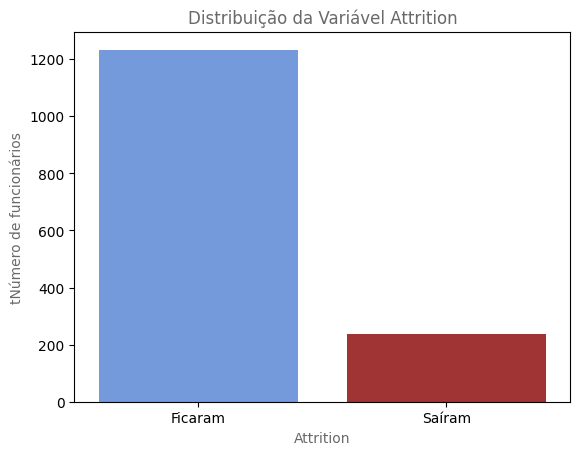

In [98]:
# analisando a variável alvo
colors = ['cornflowerblue', 'firebrick']
sns.countplot(x='Attrition', data=df, hue='Attrition', legend=False, palette=colors)
plt.title('Distribuição da Variável Attrition', color='dimgrey')
plt.xlabel('Attrition', color='dimgrey')
plt.ylabel('tNúmero de funcionários', color='dimgrey')
plt.xticks([0,1], ['Ficaram', 'Saíram'])

# verificando a proporção de attrition (target)
df['Attrition'].value_counts(normalize=True) * 100

Nota-se que existem um desbalanceamento entre as duas classes. Sendo a proporção de 'não' maior do que a de 'sim', que seria a classe que queremos avaliar. Será então necessário utilizar técnicas de balanceamento posteriormente.

### 3.5 Correlação das variáveis com o target

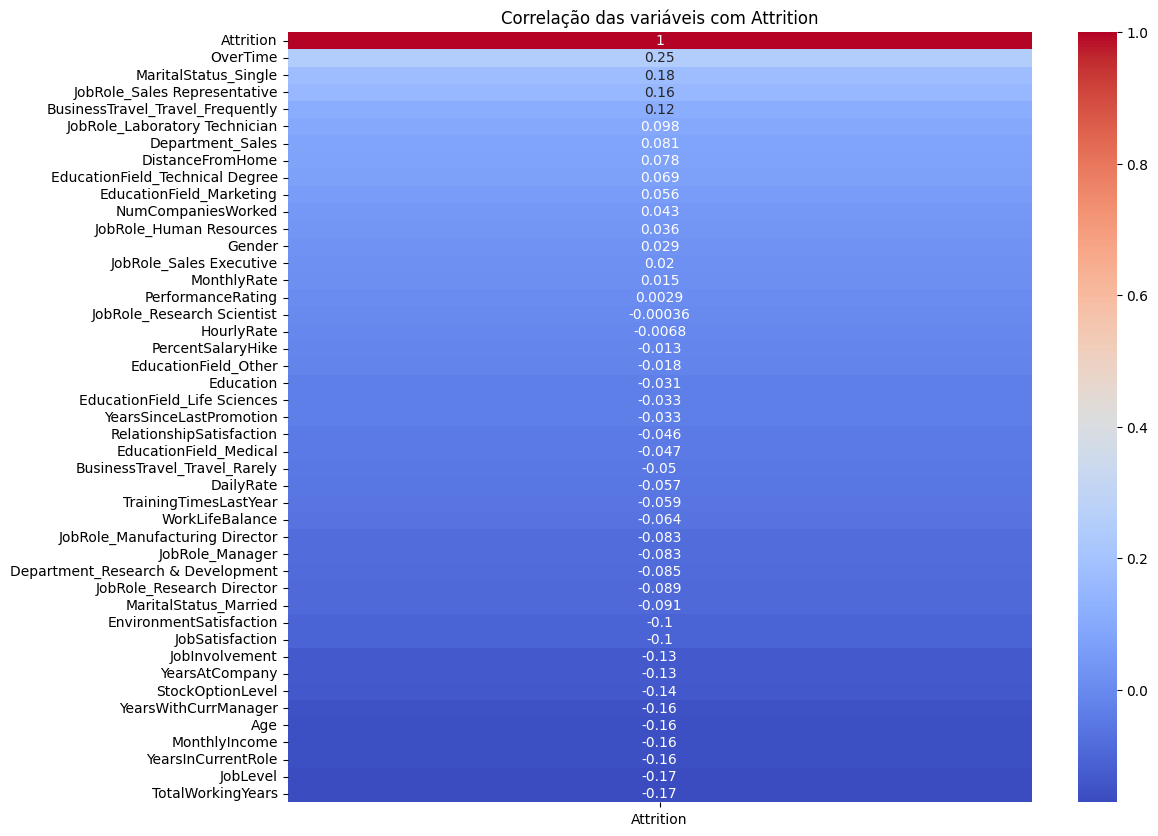

Top Positive Correlations with Attrition:
 OverTime                            0.246118
MaritalStatus_Single                0.175419
JobRole_Sales Representative        0.157234
BusinessTravel_Travel_Frequently    0.115143
JobRole_Laboratory Technician       0.098290
Name: Attrition, dtype: float64

Top Negative Correlations with Attrition:
 Age                  -0.159205
MonthlyIncome        -0.159840
YearsInCurrentRole   -0.160545
JobLevel             -0.169105
TotalWorkingYears    -0.171063
Name: Attrition, dtype: float64


In [99]:
# matriz de correlação
corr = df.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr[['Attrition']].sort_values(by='Attrition', ascending=False), annot=True, cmap='coolwarm')
plt.title('Correlação das variáveis com Attrition')
plt.show()
plt.close()

# Top correlated features with Attrition
corr_target = corr['Attrition'].drop('Attrition').sort_values(ascending=False)
print("Top Positive Correlations with Attrition:\n", corr_target.head())
print("\nTop Negative Correlations with Attrition:\n", corr_target.tail())

**Correlação com a variável Attrition**

As correlações são fracas, mas significativas. Isso é comum em problemas reais de rotatividade.

### 3.3 Distribuição das variáveis numéricas por *Attrition*

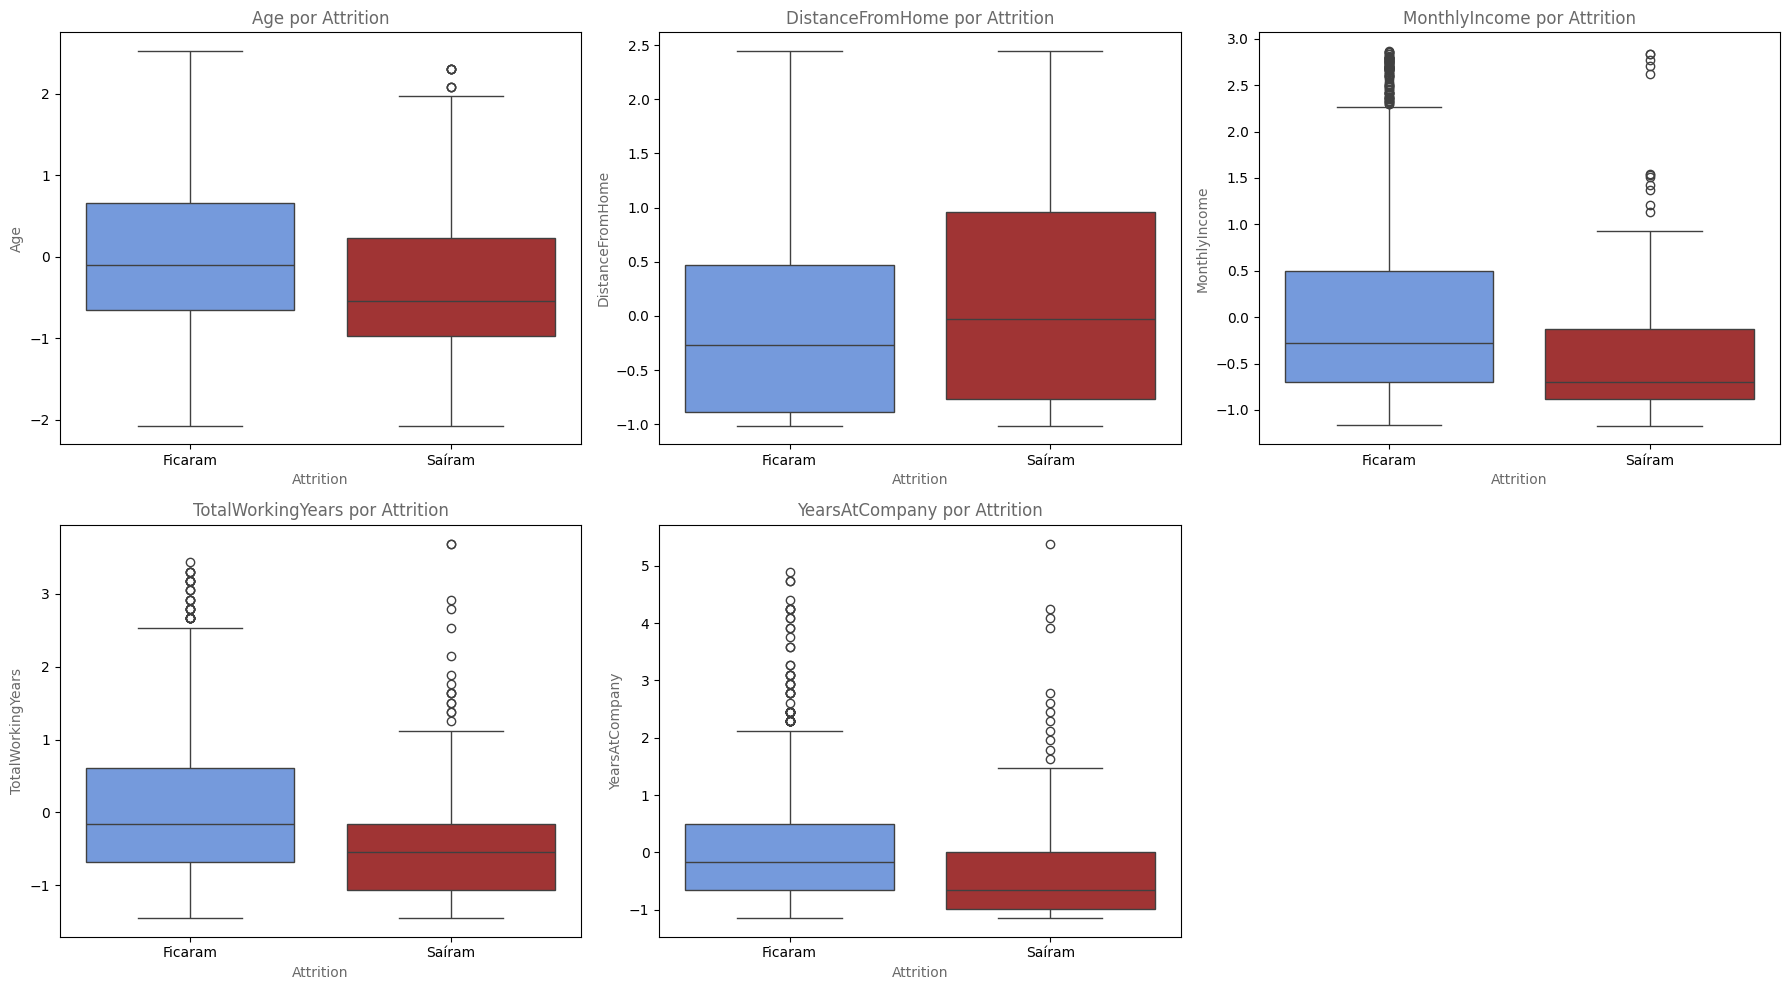

In [100]:
# boxplots
features = ['Age', 'DistanceFromHome', 'MonthlyIncome', 'TotalWorkingYears', 'YearsAtCompany']

colors = ['cornflowerblue', 'firebrick']
n_cols = 3
n_vars = len(features)
n_rows = math.ceil(n_vars / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten()

for i, num in enumerate(features):
    sns.boxplot(x='Attrition', y=num, hue='Attrition', palette=colors, data=df, legend=False, ax=axes[i])
    axes[i].set_title(f'{num} por Attrition', color='dimgrey')
    axes[i].set_xlabel('Attrition', color='dimgrey')
    axes[i].set_ylabel(num, color='dimgrey')
    axes[i].set_xticks([0,1])
    axes[i].set_xticklabels(['Ficaram', 'Saíram'])

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
plt.close()

Analisando agora os boxplots da distribuição das variáveis pela 'Attrition', identifica-se algumas com distribuição mais marcante:

1. ```MonthlyIncome```

- Alta dispersão entre os valores.

- Muitos outliers, principalmente entre os que "ficaram".

- Distribuição assimétrica.

2. ```TotalWorkingYears```

- Diferencia bem os grupos.

- Faixa ampla com outliers no topo, indicando diversidade de experiência.

3. ```YearsAtCompany```

- Distribuição bastante assimétrica, com grande concentração em valores baixos.

- Muitos outliers acima de 10 anos.

4. ```YearsInCurrentRole``` e ```YearsWithCurrManager```

- Padrões semelhantes: valores mais concentrados abaixo de 5 anos.

- Apresentam distorções com outliers acima de 10.

5. ```NumCompaniesWorked```

- Concentração nos valores baixos, mas com dispersão notável.

- Indica histórico profissional diverso.

6. ```Age```

- Variação significativa, com uma faixa ampla entre 20 e 60 anos.

- Leve assimetria e poucos outliers.

### 3.4 Distribuição das variáveis categórias por *Attrition*

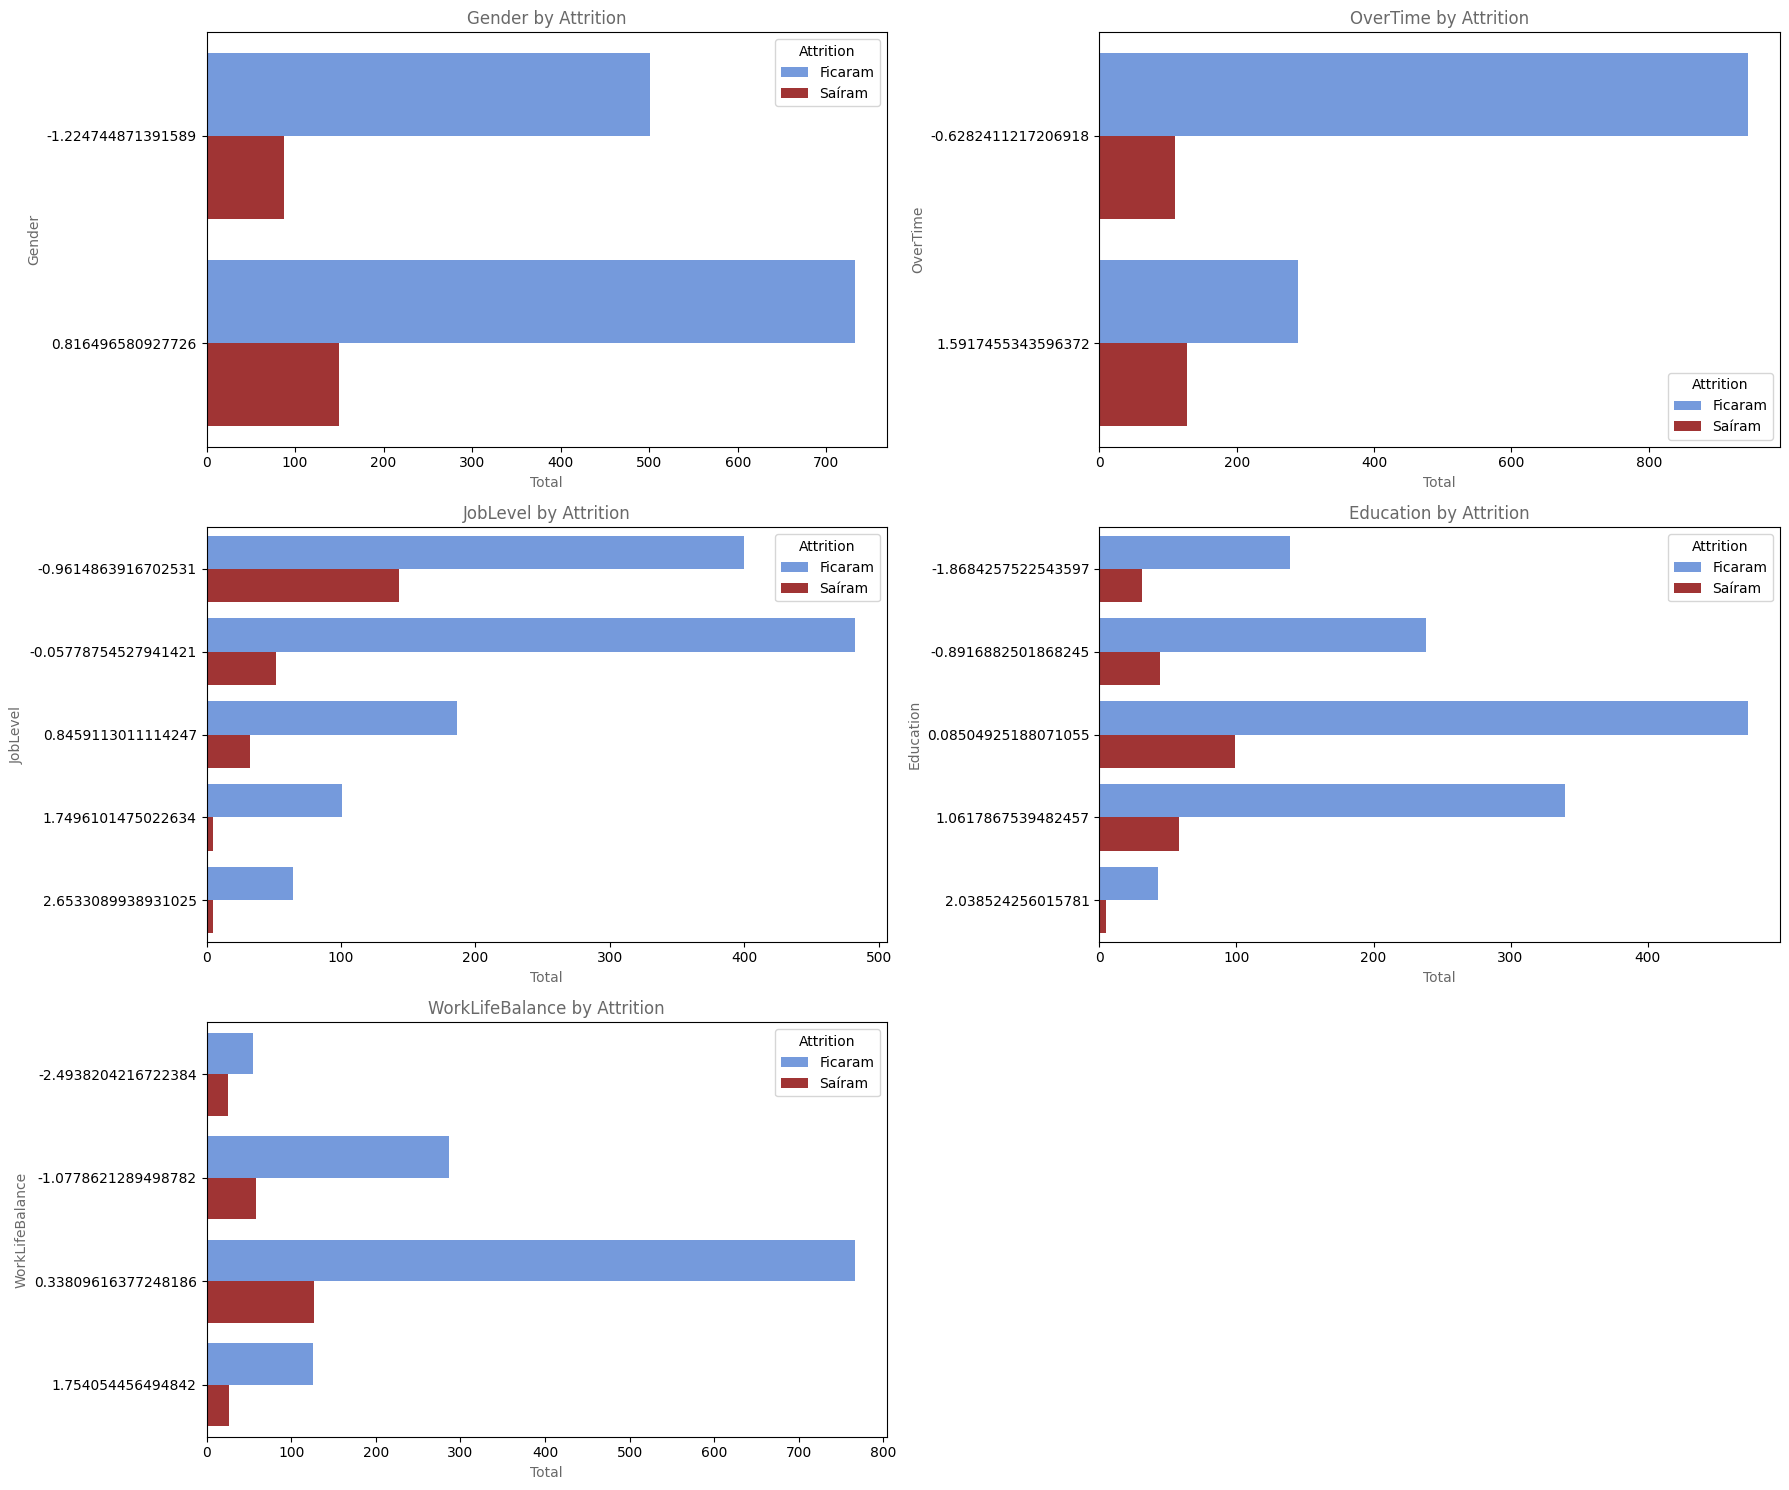

In [101]:
# gráficos de barra
categorical = ['Gender', 'OverTime', 'JobLevel', 'Education', 'WorkLifeBalance']

colors = ['cornflowerblue', 'firebrick']
n_cols = 2
n_vars = len(categorical)
n_rows = math.ceil(n_vars / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten()

for i, cat in enumerate(categorical):
    ax = sns.countplot(y=cat, hue='Attrition', palette=colors, data=df, ax=axes[i])
    ax.set_title(f'{cat} by Attrition', color='dimgrey')
    ax.set_xlabel('Total', color='dimgrey')
    ax.set_ylabel(cat, color='dimgrey')
    ax.legend(title='Attrition', labels=['Ficaram', 'Saíram'])

# Remove gráficos vazios se houver
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
plt.close()

### 🔹Etapa 4 – Modelagem Preditiva
**Objetivos:**

- Treinar pelo menos dois modelos supervisionados

- Realizar tuning de hiperparâmetros

- Comparar os modelos com base em métricas de classificação

### 4.1 Separando os dados

In [102]:
# separando dados de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### 4.2 Treinando os Modelos:

**Regressão Logística:**

In [103]:
# criar pipeline com escalonamento
pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

pipeline_lr.fit(X_train, y_train)
y_pred_lr = pipeline_lr.predict(X_test)

**XGBoost:**

In [104]:
xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    random_state=42,
    eval_metric='logloss'
)

xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

### 4.3 Impacto no Negócio:

Resultados do modelo: Regressão Logística
              precision    recall  f1-score   support

           0       0.91      0.78      0.84       247
           1       0.35      0.62      0.44        47

    accuracy                           0.75       294
   macro avg       0.63      0.70      0.64       294
weighted avg       0.82      0.75      0.78       294

Regressão Logística - Matriz de Confusão:


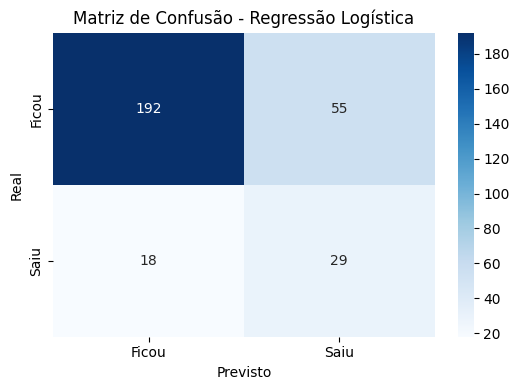

Resultados do modelo: XGBoost
              precision    recall  f1-score   support

           0       0.87      0.98      0.92       247
           1       0.62      0.21      0.32        47

    accuracy                           0.85       294
   macro avg       0.75      0.59      0.62       294
weighted avg       0.83      0.85      0.82       294


Regressão Logística - XGBoost:


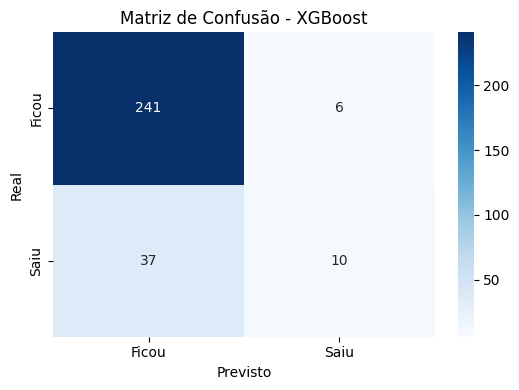

In [105]:
# regressão logística
y_pred_lr = pipeline_lr.predict(X_test)
print(f'Resultados do modelo: Regressão Logística')
print(classification_report(y_test, y_pred_lr))

# matriz de confusão - regressão logística
cm_lr = confusion_matrix(y_test, pipeline_lr.predict(X_test))
tn, fp, fn, tp = cm_lr.ravel()

# MATRIZ REGRESSÃO LOGÍSTICA
print(f'Regressão Logística - Matriz de Confusão:')
plt.figure(figsize=(5.5, 4))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', xticklabels=['Ficou', 'Saiu'], yticklabels=['Ficou', 'Saiu'])
plt.title('Matriz de Confusão - Regressão Logística')
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.tight_layout()
plt.show()

# XGBoost
y_pred_xgb = xgb_model.predict(X_test)
print(f'Resultados do modelo: XGBoost')
print(classification_report(y_test, y_pred_xgb))

# matriz de confusão - xgboost
cm_xgb = confusion_matrix(y_test, xgb_model.predict(X_test))
tn, fp, fn, tp = cm_xgb.ravel()

# MATRIZ XGBOOST
print(f'\nRegressão Logística - XGBoost:')
plt.figure(figsize=(5.5, 4))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', xticklabels=['Ficou', 'Saiu'], yticklabels=['Ficou', 'Saiu'])
plt.title('Matriz de Confusão - XGBoost')
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.tight_layout()
plt.show()



**Regressão Logística com Tuning:**

Melhores parâmetros - Regressão Logística:
{'model__C': 1, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}
Resultados do modelo: Regressão Logística
              precision    recall  f1-score   support

           0       0.91      0.78      0.84       247
           1       0.35      0.62      0.44        47

    accuracy                           0.75       294
   macro avg       0.63      0.70      0.64       294
weighted avg       0.82      0.75      0.78       294

Regressão Logística - Matriz de Confusão:


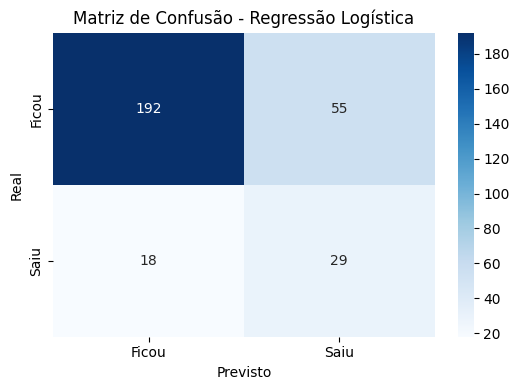

In [106]:
# criando pipeline com escalonamento
pipeline_lrt = Pipeline([('scaler', StandardScaler()),
                        ('model', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

param_grid = {
    'model__C': [0.01, 0.1, 1, 10],
    'model__penalty': ['l2'],
    'model__solver': ['lbfgs', 'liblinear']
}

grid_lrt = GridSearchCV(
    estimator=pipeline_lrt, 
    param_grid=param_grid, 
    cv=5, 
    scoring='f1', 
    n_jobs=-1)

grid_lrt.fit(X_train, y_train)

print(f'Melhores parâmetros - Regressão Logística:')
print(grid_lrt.best_params_)

# avaliando modelo
y_pred_lrt = grid_lrt.predict(X_test)
print(f'Resultados do modelo: Regressão Logística')
print(classification_report(y_test, y_pred_lrt))

# matriz de confusão - regressão logística
cm_lrt = confusion_matrix(y_test, grid_lrt.predict(X_test))
tn, fp, fn, tp = cm_lr.ravel()

# MATRIZ REGRESSÃO LOGÍSTICA
print(f'Regressão Logística - Matriz de Confusão:')
plt.figure(figsize=(5.5, 4))
sns.heatmap(cm_lrt, annot=True, fmt='d', cmap='Blues', xticklabels=['Ficou', 'Saiu'], yticklabels=['Ficou', 'Saiu'])
plt.title('Matriz de Confusão - Regressão Logística')
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.tight_layout()
plt.show()

**XGBoost com Tuning:**

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Melhores parâmetros - XGBoost:
{'subsample': 0.6, 'scale_pos_weight': 5, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.6}
Resultados do modelo: XGBoost
              precision    recall  f1-score   support

           0       0.90      0.85      0.87       247
           1       0.38      0.49      0.43        47

    accuracy                           0.79       294
   macro avg       0.64      0.67      0.65       294
weighted avg       0.82      0.79      0.80       294


Regressão Logística - XGBoost:


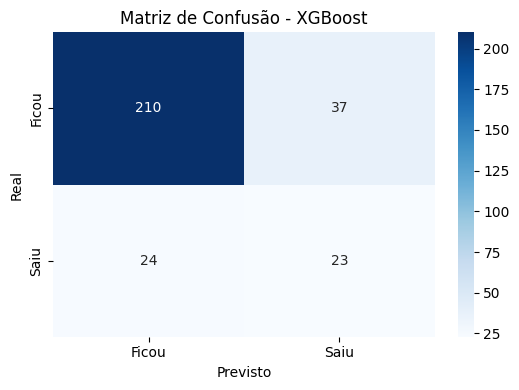

In [107]:
xgb_modelt = XGBClassifier(
    eval_metric='logloss',
    random_state=42
)

param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3,4,5,6,7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'scale_pos_weight': [1, 2, 5, 10]
}

random_search_xgb = RandomizedSearchCV(
    estimator=xgb_modelt,
    param_distributions=param_dist,
    n_iter=30, 
    scoring='f1', 
    cv=5, 
    random_state=42, 
    n_jobs=-1,
    verbose=1
)

random_search_xgb.fit(X_train, y_train)

print('Melhores parâmetros - XGBoost:')
print(random_search_xgb.best_params_)

# avaliando modelo
y_pred_xgbt = random_search_xgb.predict(X_test)
print(f'Resultados do modelo: XGBoost')
print(classification_report(y_test, y_pred_xgbt))

# matriz de confusão - xgboost com tuning
cm_xgbt = confusion_matrix(y_test, random_search_xgb.predict(X_test))
tn, fp, fn, tp = cm_xgbt.ravel()

# MATRIZ XGBOOST COM TUNING
print(f'\nRegressão Logística - XGBoost:')
plt.figure(figsize=(5.5, 4))
sns.heatmap(cm_xgbt, annot=True, fmt='d', cmap='Blues', xticklabels=['Ficou', 'Saiu'], yticklabels=['Ficou', 'Saiu'])
plt.title('Matriz de Confusão - XGBoost')
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.tight_layout()
plt.show()

Se o objetivo da empresa é identificar quem tem maior risco de sair, o modelo de Regressão Logística possui maior recall na classe 1, sendo mais seguro para ações preventivas.

### 🔹Etapa 5 – Avaliação dos modelos

- Avaliar os erros (falsos positivos e falsos negativos) e o impacto para o negócio

- Ver a importância das variáveis nos modelos, incluindo métodos para explicar o modelo (coeficientes na Regressão Logística e feature importance no XGBoost).

### 5.1 Analisando erros e impacto no negócio:

In [108]:
print(f'Regressão Logística Tuning:')
print(f'\nFalsos Positivos (FP): {fp} -> funcionários previstos para sair, mas ficaram')
print(f'Falsos Negativos (FN): {fn} -> funcionários previsto para ficar, mas saíram')

# impacto
print('\nImpacto dos erros para o negócio:')
print(f'- FP: pode gerar custos desnecesários com retenção.')
print(f'- FN: perda real, pois o funcionário sai sem ação preventiva.')

print(f'\nXGBoost Tuning:')
print(f'\nFalsos Positivos (FP): {fp} -> funcionários previstos para sair, mas ficaram')
print(f'Falsos Negativos (FN): {fn} -> funcionários previsto para ficar, mas saíram')

# impacto
print('\nImpacto dos erros para o negócio:')
print(f'- FP: custo com ações em funcionário que sairão.')
print(f'- FN: perda de funcionários sem alerta.')

Regressão Logística Tuning:

Falsos Positivos (FP): 37 -> funcionários previstos para sair, mas ficaram
Falsos Negativos (FN): 24 -> funcionários previsto para ficar, mas saíram

Impacto dos erros para o negócio:
- FP: pode gerar custos desnecesários com retenção.
- FN: perda real, pois o funcionário sai sem ação preventiva.

XGBoost Tuning:

Falsos Positivos (FP): 37 -> funcionários previstos para sair, mas ficaram
Falsos Negativos (FN): 24 -> funcionários previsto para ficar, mas saíram

Impacto dos erros para o negócio:
- FP: custo com ações em funcionário que sairão.
- FN: perda de funcionários sem alerta.


In [109]:
# resumo
print("\n🔍 Resumo de Comparação:\n")

def get_scores(name, y_test, y_pred):
    print(f"{name}")
    print(f"Accuracy : {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall   : {recall_score(y_test, y_pred):.4f}")
    print(f"F1 Score : {f1_score(y_test, y_pred):.4f}")
    print("-" * 30)

get_scores("Regressão Logística", y_test, y_pred_lr)
get_scores("Regressão Logística com Tuning", y_test, y_pred_lrt)
get_scores("XGBoost:", y_test, y_pred_xgb)
get_scores("XGBoost com Tuning:", y_test, y_pred_xgbt)


🔍 Resumo de Comparação:

Regressão Logística
Accuracy : 0.7517
Precision: 0.3452
Recall   : 0.6170
F1 Score : 0.4427
------------------------------
Regressão Logística com Tuning
Accuracy : 0.7517
Precision: 0.3452
Recall   : 0.6170
F1 Score : 0.4427
------------------------------
XGBoost:
Accuracy : 0.8537
Precision: 0.6250
Recall   : 0.2128
F1 Score : 0.3175
------------------------------
XGBoost com Tuning:
Accuracy : 0.7925
Precision: 0.3833
Recall   : 0.4894
F1 Score : 0.4299
------------------------------


### 5.2 Verificando a importância das variáveis:

**Regressão Logística com Tuning (coeficientes):**

In [110]:
# extraindo coeficientes do melhor modelo
coef = grid_lrt.best_estimator_.named_steps['model'].coef_[0]
features = X.columns

coef_df = pd.DataFrame({'feature' : features, 'coef' : coef})
coef_df['abs_coef'] = coef_df['coef'].abs()
coef_df = coef_df.sort_values(by='abs_coef', ascending=False)

print('Variáveis mais importantes:')
print(coef_df.head(10))

Variáveis mais importantes:
                             feature      coef  abs_coef
35     JobRole_Laboratory Technician  0.810172  0.810172
13                          OverTime  0.771095  0.771095
25  BusinessTravel_Travel_Frequently  0.722538  0.722538
18                 TotalWorkingYears -0.660270  0.660270
8                           JobLevel  0.650173  0.650173
41      JobRole_Sales Representative  0.531090  0.531090
26      BusinessTravel_Travel_Rarely  0.512780  0.512780
29      EducationField_Life Sciences -0.512319  0.512319
23           YearsSinceLastPromotion  0.499063  0.499063
28                  Department_Sales  0.470587  0.470587


Text(0, 0.5, 'feature')

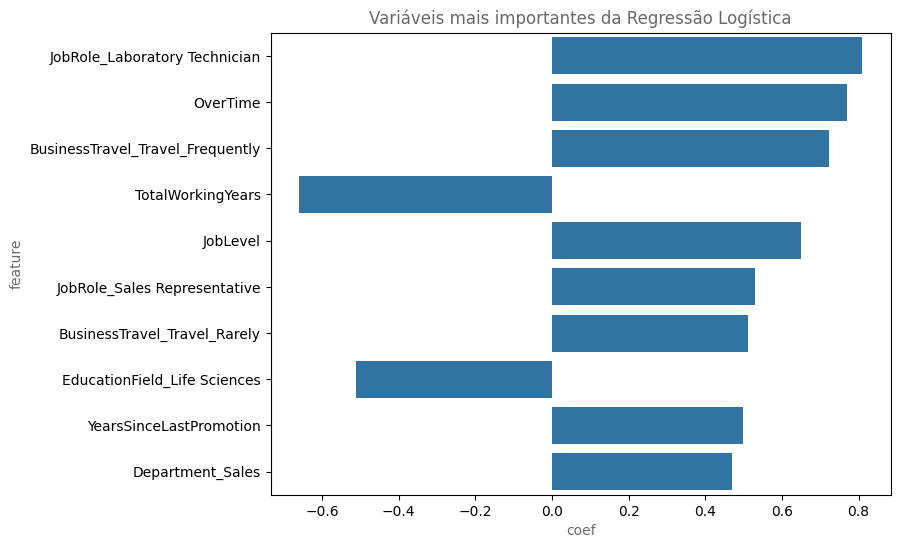

In [111]:
# visualização
plt.figure(figsize=(8,6))
sns.barplot(x='coef', y='feature', data=coef_df.head(10))
plt.title('Variáveis mais importantes da Regressão Logística', color='dimgrey')
plt.xlabel('coef', color='dimgrey')
plt.ylabel('feature', color='dimgrey')

**XGBoost (feature importance):**

In [112]:
# extraindo features do melhor modelo
xgb_best = random_search_xgb.best_estimator_

Text(0, 0.5, 'Features')

<Figure size 1000x600 with 0 Axes>

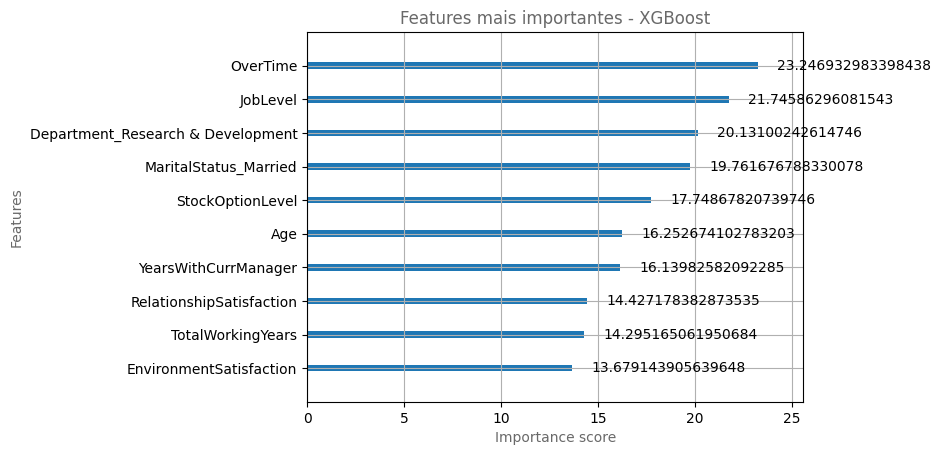

In [113]:
# visualização
plt.figure(figsize=(10,6))
plot_importance(xgb_best, max_num_features=10, importance_type='gain')
plt.title('Features mais importantes - XGBoost', color='dimgrey')
plt.xlabel('Importance score', color='dimgrey')
plt.ylabel('Features', color='dimgrey')

### 5.3 Explicação com SHAP (XGBoost):

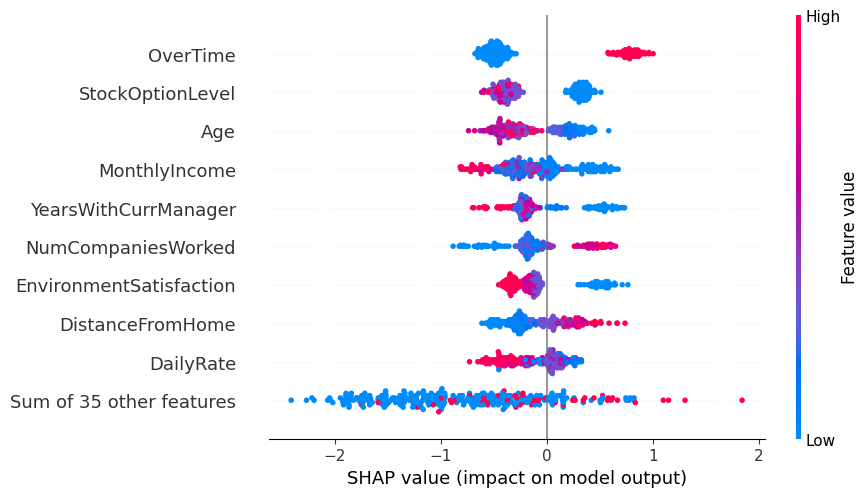

In [114]:
# inicializando o explainer
explainer = shap.Explainer(random_search_xgb.best_estimator_)
shap_values = explainer(X_test)

# resumo geral: o que mais influencia o modelo
shap.plots.beeswarm(shap_values, max_display=10)

O gráfico acima mostra as variáveis mais impactantes para as previsões do modelo. Cada ponto representa um colaborador do conjunto de teste, e a cor indica o valor da variável (azul = valor baixo, rosa = valor alto).

**Principais insights do SHAP**

```OverTime_Yes```: Funcionários que fazem hora extra (valores altos = rosa) têm maior probabilidade de pedir desligamento (valores SHAP positivos). Essa foi a variável com maior impacto no modelo.

```StockOptionLevel```: Funcionários com menor nível de opções de ações (azul) tendem a sair mais — mostrando que benefícios financeiros impactam na retenção.

```Age```: Funcionários mais jovens (azul) estão mais propensos a sair, possivelmente buscando novas oportunidades ou insatisfeitos com a estabilidade atual.

```NumCompaniesWorked```: Quanto mais empresas o colaborador já trabalhou (rosa), maior a chance de sair — pode indicar instabilidade no histórico profissional.

```YearsWithCurrManager```: Valores baixos (azul) indicam pouca convivência com o gestor atual, o que pode impactar negativamente no vínculo com a empresa.

Mesmo o XGBoost não sendo o melhor modelo final, sua explicabilidade com SHAP revela padrões valiosos de comportamento dos colaboradores.

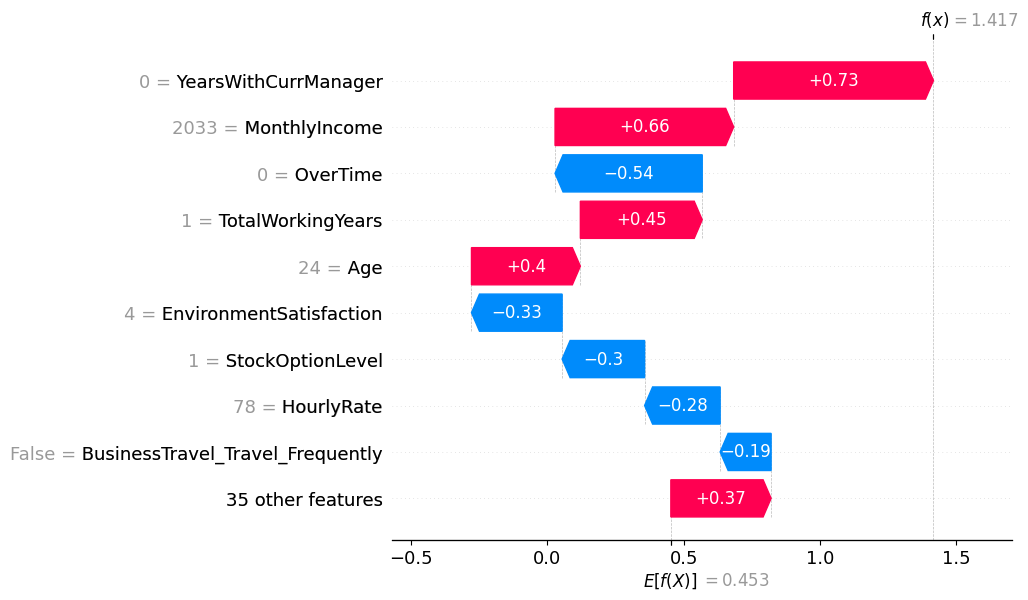

In [115]:
# explicando o primerio exemplo do X_test
shap.plots.waterfall(shap_values[0])

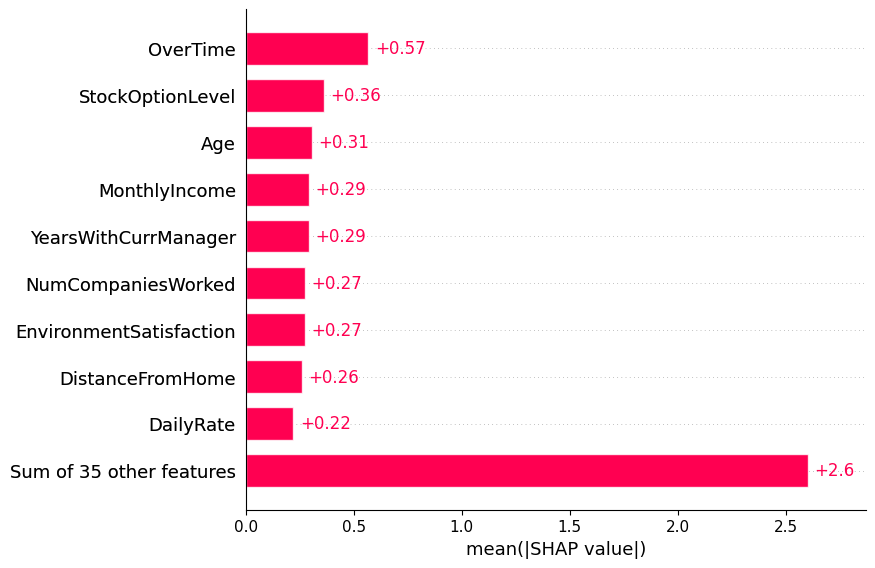

In [116]:
# feature importance simplificada
shap.plots.bar(shap_values, max_display=10)

Acima, temos o gráfico com as variáveis mais relevantes para o modelo XGBoost, gerado a partir dos valores médios absolutos de SHAP. O valor no final de cada barra representa o impacto médio (positivo ou negativo) que aquela variável teve nas previsões.

**Principais insights:**

```OverTime_Yes```: Foi a variável mais impactante. Funcionários que fazem hora extra estão mais propensos a sair da empresa.

```StockOptionLevel```: Colaboradores com menor nível de opção de ações tendem a pedir demissão mais frequentemente.

```Age```: Idade influenciou bastante: funcionários mais jovens demonstram maior propensão à rotatividade.

```NumCompaniesWorked```: Histórico com muitas empresas anteriores indica maior chance de saída.

```YearsWithCurrManager```: Pouco tempo com o mesmo gestor pode refletir menor vínculo com a equipe.

```MonthlyIncome```: Remunerações mais baixas também influenciam negativamente na retenção.

```EnvironmentSatisfaction```: Níveis mais baixos de satisfação no ambiente de trabalho aumentam o risco de saída.

### 🔹Etapa 6 – Relatório/Apresentação de Resultados

**Modelos Treinados:** Regressão Logística, XGBoost
**Tuning com Hiperparâmetros:** Regressão Logística e XGBoost
**Feature Importance:** Regressão Logística

---

**Modelo Recomendado:** 

- Regressão Logística: Melhor modelo para prever quem realmente sai.
- XGBoost: Baixo recall.

### Recomendações Práticas para o RH da Data Girls S.A

1. Reduzir horas extras, pois sobrecarga está diretamente ligada ao risco de saída.

2. Oferecer incentivos financeiros, como opções de ações, especialmente para colaboradores mais jovens.

3. Investir na relação líder-equipe, monitorando funcionários com pouco tempo sob o mesmo gestor.

4. Fortalecer a satisfação organizacional com programas de bem-estar, clima e reconhecimento.

5. Priorizar ações de retenção para perfis com histórico instável de emprego.

## Conclusão

A Regressão Logística apresentou melhor performance na identificação de possíveis desligamentos, enquanto o XGBoost forneceu uma excelente base de explicação com SHAP. A combinação dos dois modelos permite não apenas prever o turnover, mas entender e justificar os motivos por trás dessas decisões, permitindo que a empresa atue de forma estratégica e preventiva.